# Поиск Новой Физики

В этой тетрадке приведен простой пример решения задачи Новой Физики в соревновании LHC Olympics 2020 https://lhco2020.github.io/homepage.

Решение реализовано по мотивам статьи "Classifying Anomalies THrough Outer Density Estimation (CATHODE)" https://arxiv.org/abs/2109.00546. А именно, используется подход CWoLa.

In [1]:
import pandas as pd
import numpy as np
import os
import argparse

## Данные

Мы используем R&D Dataset for LHC Olympics 2020 Anomaly Detection Challenge (https://zenodo.org/records/4536377). Данные и их описание доступны по ссылке.

In [2]:
# the "data" containing too much signal
features = pd.read_hdf("../data/events_anomalydetection_v2.features.h5")

In [3]:
features

,pxj1,pyj1,pzj1,mj1,tau1j1,tau2j1,tau3j1,pxj2,pyj2,pzj2,mj2,tau1j2,tau2j2,tau3j2,label
0,-1467.239990,611.502014,511.101990,38.896000,8.290660,4.836080,4.260190,1403.579956,-674.551025,-451.670990,237.893997,79.815102,21.010300,16.757601,0.0
1,-1211.239990,347.315002,547.963013,389.532013,191.804001,99.562798,70.872200,619.341003,-62.177299,-1944.040039,22.999201,8.042190,6.335090,5.525360,0.0
2,-1229.619995,649.857971,8.089170,72.155502,47.168098,37.243198,33.658199,1196.250000,-647.896973,-1283.109985,78.230698,15.292900,13.944200,10.013500,0.0
3,-693.304016,-1046.729980,1716.910034,55.797798,24.788601,6.890150,5.813390,747.961975,994.250000,-412.966003,359.113007,175.209000,103.500999,84.447098,0.0
4,-1488.199951,-25.370100,-30.989700,84.891502,26.878799,15.517200,13.260400,1415.640015,20.905100,223.630997,77.506500,57.986000,34.147400,26.660601,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099995,1069.660034,659.874023,218.751007,126.183998,122.486000,27.608700,17.924801,-956.169006,-297.311005,-2204.350098,108.889999,21.177299,10.582400,9.138600,1.0
1099996,-1286.619995,-86.162498,-1366.270020,115.719002,109.853996,29.830200,22.489201,1145.729980,136.792007,1216.780029,489.053009,416.747009,84.599998,66.767502,1.0
1099997,-149.330002,1781.459961,-58.690899,508.045013,495.290985,82.283600,43.567902,84.726700,-1378.569946,-1485.469971,91.104897,79.120102,46.537300,23.227301,1.0
1099998,1584.699951,-731.156982,-196.348007,114.938004,83.769897,12.898200,9.031230,-1515.079956,783.245972,498.704010,553.737000,366.188995,192.139008,81.398201,1.0


## Физическая предобработка данных

Выделяем и рассчитываем необходимы признаки для решения задачи.

In [4]:
# Read from data
mj1mj2 = np.array(features[['mj1','mj2']])
tau21  = np.array(features[['tau2j1','tau2j2']]) / (1e-5 + np.array(features[['tau1j1','tau1j2']]))

In [5]:
# Sorting of mj1 and mj2:
# Identifies which column has the minimum of mj1 and mj2, and sorts it so the new array mjmin contains the 
# mj with the smallest energy, and mjmax is the one with the biggest.
mjmin = mj1mj2[range(len(mj1mj2)), np.argmin(mj1mj2, axis=1)] 
mjmax = mj1mj2[range(len(mj1mj2)), np.argmax(mj1mj2, axis=1)]

In [6]:
# Then we do the same sorting for the taus
tau21min = tau21[range(len(mj1mj2)), np.argmin(mj1mj2, axis=1)]
tau21max = tau21[range(len(mj1mj2)), np.argmax(mj1mj2, axis=1)]

In [7]:
# Calculate mjj and collect the features into a dataset, plus mark signal/bg with 1/0
pjj = np.array(features[['pxj1','pyj1','pzj1']]) + np.array(features[['pxj2','pyj2','pzj2']])
Ejj = np.sqrt(np.sum(np.array(features[['pxj1','pyj1','pzj1','mj1']])**2, axis=1)) \
    + np.sqrt(np.sum(np.array(features[['pxj2','pyj2','pzj2','mj2']])**2, axis=1))
mjj = np.sqrt(Ejj**2 - np.sum(pjj**2, axis=1))

In [8]:
label = features['label'].values

In [9]:
# format of data_all: mjj (TeV), mjmin (TeV), mjmax-mjmin (TeV), tau21(mjmin), tau21 (mjmax), sigorbg label
dataset = np.dstack((mjj/1000, mjmin/1000, (mjmax - mjmin)/1000, tau21min, tau21max, label))[0]

dataset.shape

(1100000, 6)

In [10]:
dataset_sig = dataset[label==1]
dataset_bg = dataset[label==0]

dataset_sig.shape, dataset_bg.shape

((100000, 6), (1000000, 6))

## Удаление лишних сигнальных событий

Убираем из данных лишние сигнальные события, чтобы отношение сигнал/шум (S/B) соответствовало условиям реального физического эксперимента.

In [11]:
seed = 42
S_over_B = -1

np.random.seed(seed) # Set the random seed so we get a deterministic result
np.random.shuffle(dataset_sig)

if S_over_B==-1:
    n_sig = 1000
else:
    n_sig = int(S_over_B*1000/0.006361658645922605)

data_all = np.concatenate((dataset_bg, dataset_sig[:n_sig]))
indices = np.array(range(len(data_all))).astype('int')
np.random.shuffle(indices)
data_all = data_all[indices]

In [12]:
data_all.shape

(1001000, 6)

## Делим данные на обучение и валидацию

In [13]:
# format of data_all: mjj (TeV), mjmin (TeV), mjmax-mjmin (TeV), tau21(mjmin), tau21 (mjmax), sigorbg label
minmass = 3.3
maxmass = 3.7
dmass = 0.2

innermask = (data_all[:,0] > minmass) & (data_all [:,0] < maxmass)
outermask = ((data_all[:,0] > minmass - dmass) & (data_all [:,0] < minmass)) | ((data_all[:,0] > maxmass) & (data_all [:,0] < maxmass + dmass)) 

innerdata = data_all[innermask]
outerdata = data_all[outermask]

In [14]:
innerdata.shape, outerdata.shape

((122097, 6), (130251, 6))

In [15]:
from sklearn.model_selection import train_test_split

outerdata_train, outerdata_val = train_test_split(outerdata, train_size=0.5, random_state=11)
innerdata_train, innerdata_val = train_test_split(innerdata, train_size=0.5, random_state=11)

In [16]:
outerdata_train.shape, outerdata_val.shape

((65125, 6), (65126, 6))

In [17]:
innerdata_train.shape, innerdata_val.shape

((61048, 6), (61049, 6))

Добавляем остальной сигнал в валидационную выборку для подсчета метрик.

In [18]:
innerdata_extrasig = dataset_sig[n_sig:]
innermask_extrasig = (innerdata_extrasig[:,0] > minmass) & (innerdata_extrasig [:,0] < maxmass)
innerdata_extrasig = innerdata_extrasig[innermask_extrasig]

innerdata_val_extra = np.vstack((innerdata_val, innerdata_extrasig))

In [19]:
innerdata_val_extra.shape

(135603, 6)

## Обучаем классификатор

Классификатор обучается отделять сигналы в SR (innerdata) от SB (outerdata). Предполагается, что SB содержит только фоновые (шумовые) события, а SR содержит как фон, так сигнал.

In [20]:
X_train = np.vstack((outerdata_train[:, 1:5], innerdata_train[:, 1:5]))
y_train = np.array([0]*len(outerdata_train) + [1]*len(innerdata_train))

X_val = np.vstack((outerdata_val[:, 1:5], innerdata_val[:, 1:5]))
y_val = np.array([0]*len(outerdata_val) + [1]*len(innerdata_val))

In [21]:
X_train.shape, y_train.shape

((126173, 4), (126173,))

In [22]:
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

model = CatBoostClassifier(
    iterations=1000,           # количество итераций (деревьев)
    learning_rate=0.001,         # скорость обучения
    depth=6,                   # глубина деревьев
    loss_function='Logloss',   # функция потерь для бинарной классификации
    random_seed=42,
    verbose=100,               # вывод лога каждые 100 итераций
)

# model = RandomForestClassifier(n_estimators=1000, n_jobs=-1)

/home/mhushchyn/.conda/envs/missing_anomaly_ts/lib/python3.11/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [23]:
model.fit(X_train, y_train)

TBB Warning: The number of workers is currently limited to 3. The request for 47 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



0:	learn: 0.6931470	total: 65.5ms	remaining: 1m 5s
100:	learn: 0.6930054	total: 833ms	remaining: 7.42s
200:	learn: 0.6928849	total: 1.54s	remaining: 6.11s
300:	learn: 0.6927784	total: 2.25s	remaining: 5.23s
400:	learn: 0.6926833	total: 3.01s	remaining: 4.49s
500:	learn: 0.6925971	total: 3.73s	remaining: 3.71s
600:	learn: 0.6925204	total: 4.46s	remaining: 2.96s
700:	learn: 0.6924528	total: 5.22s	remaining: 2.23s
800:	learn: 0.6923906	total: 5.94s	remaining: 1.48s
900:	learn: 0.6923331	total: 6.69s	remaining: 735ms
999:	learn: 0.6922765	total: 7.45s	remaining: 0us


## Делаем прогноз сигнальных событий в SR (innerdata)

In [24]:
predictions_inner = model.predict_proba(innerdata_val_extra[:, 1:5])[:, 1]
sigorbg_label = innerdata_val_extra[:, 5]

## Метрики качества

Строим физические аналоги ROC кривых

In [25]:
from sklearn.metrics import roc_auc_score, roc_curve
fpr, tpr, thresholds = roc_curve(sigorbg_label, predictions_inner)
fpr_nonzero = np.delete(fpr, np.argwhere(fpr == 0))
tpr_nonzero = np.delete(tpr, np.argwhere(fpr == 0))
sic = tpr_nonzero/fpr_nonzero**0.5

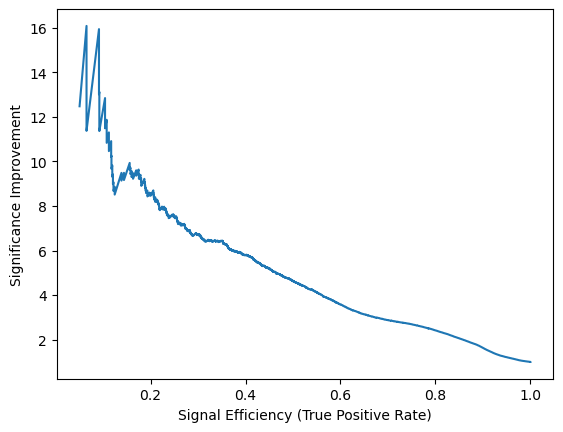

In [26]:
import matplotlib.pyplot as plt

plt.plot(tpr_nonzero, sic)
plt.xlabel('Signal Efficiency (True Positive Rate)')
plt.ylabel('Significance Improvement')
plt.show()

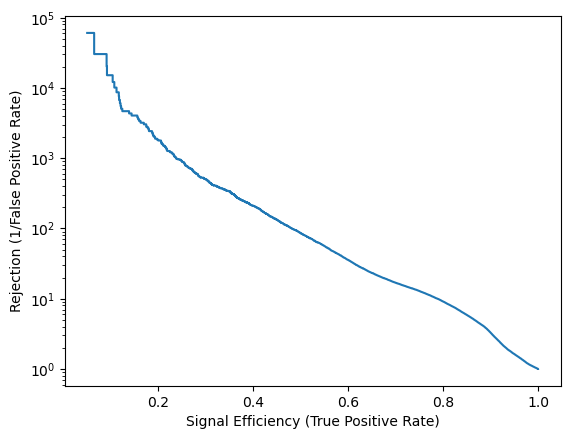

In [27]:
plt.plot(tpr_nonzero, 1/fpr_nonzero)
plt.yscale('log')
plt.xlabel('Signal Efficiency (True Positive Rate)')
plt.ylabel('Rejection (1/False Positive Rate)')
plt.show()